In [20]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire
| YrFireName                  | Year and name of the fire                                    
| Times_burned                | The number of times this tree was burned                           
| Species                     | Symbol for species                                                 
| Genus_species               | Genus and species of tree                                      
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

/tmp/ipykernel_1353440/1765753220.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


In [3]:
# select only the desired columns
trees_dat = trees_dat[['yr1status','YrFireName','Times_burned','Species','Genus_species','DBH_cm','HT_m','CR_pre','CR_post']]

In [4]:
# drop the na's
trees_dat = trees_dat.dropna(axis=0)

In [7]:
print(f"There are {trees_dat.shape[0]} observations left.")
# this gives us the number of observations left after dropping the incomplete ones

There are 36509 observations left.


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [8]:
trees_dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36509 entries, 500 to 169336
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr1status      36509 non-null  float64
 1   YrFireName     36509 non-null  object 
 2   Times_burned   36509 non-null  int64  
 3   Species        36509 non-null  object 
 4   Genus_species  36509 non-null  object 
 5   DBH_cm         36509 non-null  float64
 6   HT_m           36509 non-null  float64
 7   CR_pre         36509 non-null  float64
 8   CR_post        36509 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 2.8+ MB


In [9]:
# Recode categorical predictors to zero-based integer form
for col in ['Genus_species', 'YrFireName', 'Species']:
    trees_dat[col],_ = pd.factorize(trees_dat[col], sort=True)
    
# Check
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post
500,0.0,37,1,0,0,71.374,41.76,0.84,0.74
501,0.0,37,1,0,0,23.622,12.80,0.60,0.57
502,0.0,37,1,0,0,46.228,34.75,0.75,0.59
503,0.0,37,1,0,0,21.082,23.16,0.38,0.38
504,0.0,37,1,0,0,24.384,26.21,0.42,0.42


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [16]:
# Assign predictor and outcome variables 
X = trees_dat.loc[:, trees_dat.columns != 'yr1status']
y = trees_dat[['yr1status']]

# Establish train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Apply the scaling to training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [17]:
train_set_size = len(X_train) + len(y_train)
test_set_size = len(X_test) + len(y_test)

# Verify the training and testing set size
print("Training set observations:", train_set_size)
print("Testing set observations:", test_set_size)

Training set observations: 51112
Testing set observations: 21906


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [18]:
# Create classifier and fit model
model = LogisticRegression().fit(X_train_scaled, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train_scaled)

# Calculate and print the accuracy of your model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.9419314446705275


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.9463160777869077


Text(0.5, 1.0, 'Confusion Matrix')

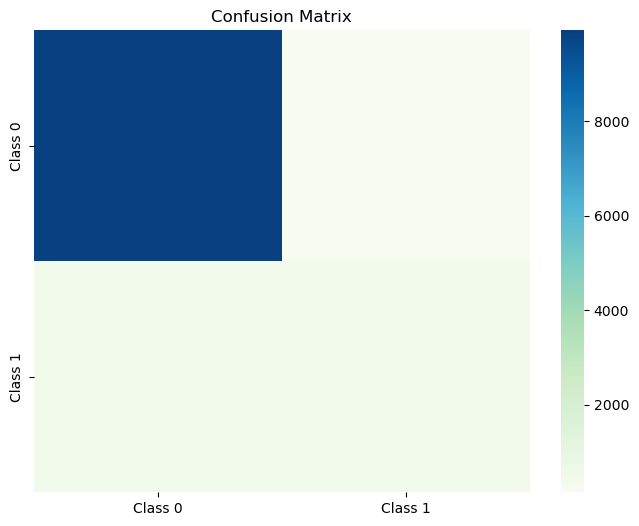

In [23]:
# Make predictions on our test set using our model
y_test_pred = model.predict(X_test_scaled)

# Calculate accuracy and confusion matrix
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {test_accuracy}")


#Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (8,6))
sns.heatmap(cm, fmt = 'd', cmap = 'GnBu',
               xticklabels = ['Class 0', 'Class 1'],
               yticklabels = ['Class 0', 'Class 1'])
plt.title('Confusion Matrix')

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model did --- cut off here!!!

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

*Your answer here*

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [ ]:
...

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: ")
print("\nDummy Confusion Matrix:")


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [ ]:
# Logistic classifier AUC
...
print(f"Logistic AUC: ")

In [ ]:
# Dummy classifier AUC
...
print(f"Dummy AUC: ")

# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*Your answer here*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [ ]:
...

# Print the sorted feature importance
print(importance_df)

Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

*Your answer here*